In [3]:
# Install required packages
!pip install astral pytorch-tabnet seaborn

# Import for data manipulation
import pandas as pd
import numpy as np

# Import for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import for sunrise/sunset calculation and time handling
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timedelta

# Import for machine learning with scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Import for TabNet deep learning model
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# Set Seaborn styling and display full DataFrame columns
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

In [4]:
# Load the Excel file (adjust filename if needed)
df = pd.read_excel('Chelsea Bridge logs.xlsx')  # Replace with your actual filename

# Display the first few rows
df.head()


,Start Time,End Time,Duration,Direction,Vessel(s)
0,2019-05-06 15:12:00,2019-05-06 15:30:00,00:18:00,IN,Freedom/Christian Reinauer/RTC 145
1,2019-05-07 17:52:00,2019-05-07 18:06:00,00:14:00,IN,Freedom/DBL 104/Denali
2,2019-05-07 18:55:00,2019-05-07 19:10:00,00:15:00,IN,Freedom
3,2019-05-08 18:37:00,2019-05-08 18:53:00,00:16:00,IN,Freedom/Elens Bouchard/B.NO. 280
4,2019-05-09 07:45:00,2019-05-09 08:00:00,00:15:00,IN,Vincent D Tibbestts


In [5]:
# Install necessary libraries
!pip install astral requests pandas NOAA


  Preparing metadata (setup.py) ... done
  Created wheel for NOAA: filename=noaa-0.2.1-py3-none-any.whl size=8357 sha256=607c6422b4595fcb4a96945edd0461f2f9f852ccbffdc673bd099d99646cf05e
  Stored in directory: /root/.cache/pip/wheels/e2/c5/11/85b6841178529d2872944df3576de98aedff777dfd5b75ff25
Successfully built NOAA


In [5]:
# Step 1: Load the original Chelsea Bridge dataset and parse datetime columns
df = pd.read_excel('Chelsea Bridge logs.xlsx', parse_dates=['Start Time', 'End Time'])

# Convert duration (HH:MM:SS) into total minutes as a numeric column
df['Duration_min'] = df['Duration'].apply(lambda x: x.hour * 60 + x.minute + x.second / 60)

# Extract the date part of 'Start Time' for use in sunrise/sunset calculation
df['Date'] = df['Start Time'].dt.date

# Step 2: Add sunrise and sunset times based on Chelsea Bridge location
location = LocationInfo(name="Chelsea Bridge", region="MA",
                        timezone="America/New_York",
                        latitude=42.3876, longitude=-71.0378)

# Define a function to get sunrise and sunset for a given date
def get_sun_times(date):
    s = sun(location.observer, date=date, tzinfo=location.timezone)
    return s['sunrise'], s['sunset']

# Apply the sun time function to every row and store results in new columns
df[['Sunrise', 'Sunset']] = df['Date'].apply(
    lambda d: pd.Series(get_sun_times(d))
)

# Step 3: Simulate tide height at lift start time using a sinusoidal pattern + noise
np.random.seed(42)  # Ensure reproducibility
df['Tide_at_start'] = 1.5 + 0.8 * np.sin(df['Start Time'].dt.hour / 24 * 2 * np.pi) + np.random.normal(0, 0.1, len(df))

# Step 4: Simulate weather features (temperature, wind speed, precipitation)
# Temperature varies by month in a sine wave pattern
df['Temp_C'] = 5 + 15 * np.sin((df['Start Time'].dt.month - 1) / 12 * 2 * np.pi) + np.random.normal(0, 2, len(df))

# Random wind speed between 1 and 7 m/s
df['Wind_ms'] = np.random.uniform(1, 7, len(df))

# Random choice of precipitation values with probabilities
df['Precip_mm'] = np.random.choice([0, 0.2, 0.5, 1, 2], size=len(df), p=[0.7, 0.1, 0.1, 0.05, 0.05])

# Step 5: Save the final enriched dataset with environmental and time-based features
df.to_csv('enriched_bridge_data.csv', index=False)

# Display the first few rows to confirm structure
df.head()

,Start Time,End Time,Duration,Direction,Vessel(s),Duration_min,Date,Sunrise,Sunset,Tide_at_start,Temp_C,Wind_ms,Precip_mm
0,2019-05-06 15:12:00,2019-05-06 15:30:00,00:18:00,IN,Freedom/Christian Reinauer/RTC 145,18.0,2019-05-06,2019-05-06 05:33:24.175434-04:00,2019-05-06 19:48:51.435248-04:00,0.983986,16.045785,4.765640,0.0
1,2019-05-07 17:52:00,2019-05-07 18:06:00,00:14:00,IN,Freedom/DBL 104/Denali,14.0,2019-05-07,2019-05-07 05:32:09.985131-04:00,2019-05-07 19:49:57.053456-04:00,0.713433,17.089874,5.619148,0.5
2,2019-05-07 18:55:00,2019-05-07 19:10:00,00:15:00,IN,Freedom,15.0,2019-05-07,2019-05-07 05:32:09.985131-04:00,2019-05-07 19:49:57.053456-04:00,0.764769,16.478373,4.289295,0.0
3,2019-05-08 18:37:00,2019-05-08 18:53:00,00:16:00,IN,Freedom/Elens Bouchard/B.NO. 280,16.0,2019-05-08,2019-05-08 05:30:57.211261-04:00,2019-05-08 19:51:02.364706-04:00,0.852303,18.438235,4.237022,0.2
4,2019-05-09 07:45:00,2019-05-09 08:00:00,00:15:00,IN,Vincent D Tibbestts,15.0,2019-05-09,2019-05-09 05:29:45.886625-04:00,2019-05-09 19:52:07.340803-04:00,2.249325,14.097330,1.529406,0.0


In [6]:
# Load the enriched dataset from the CSV created earlier
# This file includes engineered features like Duration_min, sunrise, tide, weather, etc.
df = pd.read_csv('enriched_bridge_data.csv', parse_dates=['Start Time', 'End Time', 'Sunrise', 'Sunset'])

# Check the structure and data types of the loaded DataFrame
# Helps confirm that datetime fields are correctly parsed and there are no missing values
df.info()

# Display the first few rows to visually inspect the loaded data
df.head()


<ipython-input-6-3449076505>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df = pd.read_csv('enriched_bridge_data.csv', parse_dates=['Start Time', 'End Time', 'Sunrise', 'Sunset'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7309 entries, 0 to 7308
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Start Time     7309 non-null   datetime64[ns]
 1   End Time       7309 non-null   datetime64[ns]
 2   Duration       7309 non-null   object        
 3   Direction      7309 non-null   object        
 4   Vessel(s)      7309 non-null   object        
 5   Duration_min   7309 non-null   float64       
 6   Date           7309 non-null   object        
 7   Sunrise        7309 non-null   object        
 8   Sunset         7309 non-null   object        
 9   Tide_at_start  7309 non-null   float64       
 10  Temp_C         7309 non-null   float64       
 11  Wind_ms        7309 non-null   float64       
 12  Precip_mm      7309 non-null   float64       
dtypes: datetime64[ns](2), float64(5), object(6)
memory usage: 742.4+ KB


,Start Time,End Time,Duration,Direction,Vessel(s),Duration_min,Date,Sunrise,Sunset,Tide_at_start,Temp_C,Wind_ms,Precip_mm
0,2019-05-06 15:12:00,2019-05-06 15:30:00,00:18:00,IN,Freedom/Christian Reinauer/RTC 145,18.0,2019-05-06,2019-05-06 05:33:24.175434-04:00,2019-05-06 19:48:51.435248-04:00,0.983986,16.045785,4.765640,0.0
1,2019-05-07 17:52:00,2019-05-07 18:06:00,00:14:00,IN,Freedom/DBL 104/Denali,14.0,2019-05-07,2019-05-07 05:32:09.985131-04:00,2019-05-07 19:49:57.053456-04:00,0.713433,17.089874,5.619148,0.5
2,2019-05-07 18:55:00,2019-05-07 19:10:00,00:15:00,IN,Freedom,15.0,2019-05-07,2019-05-07 05:32:09.985131-04:00,2019-05-07 19:49:57.053456-04:00,0.764769,16.478373,4.289295,0.0
3,2019-05-08 18:37:00,2019-05-08 18:53:00,00:16:00,IN,Freedom/Elens Bouchard/B.NO. 280,16.0,2019-05-08,2019-05-08 05:30:57.211261-04:00,2019-05-08 19:51:02.364706-04:00,0.852303,18.438235,4.237022,0.2
4,2019-05-09 07:45:00,2019-05-09 08:00:00,00:15:00,IN,Vincent D Tibbestts,15.0,2019-05-09,2019-05-09 05:29:45.886625-04:00,2019-05-09 19:52:07.340803-04:00,2.249325,14.097330,1.529406,0.0


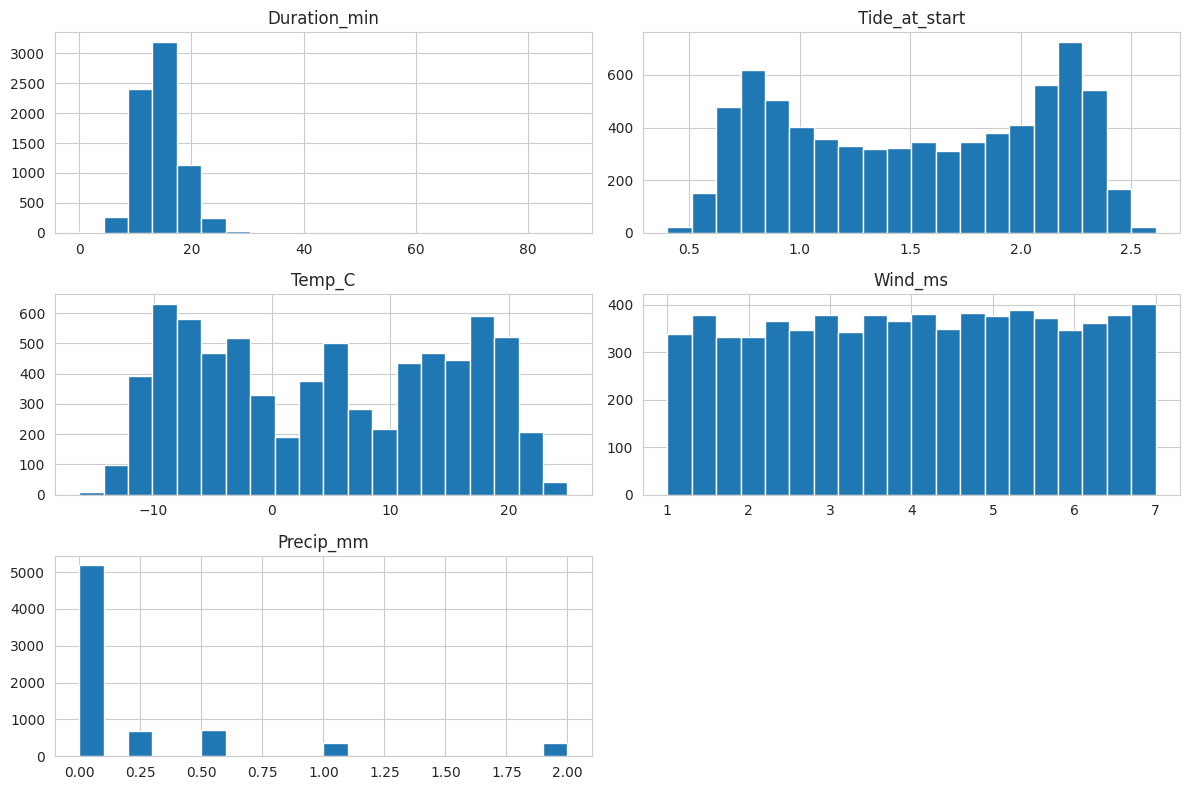

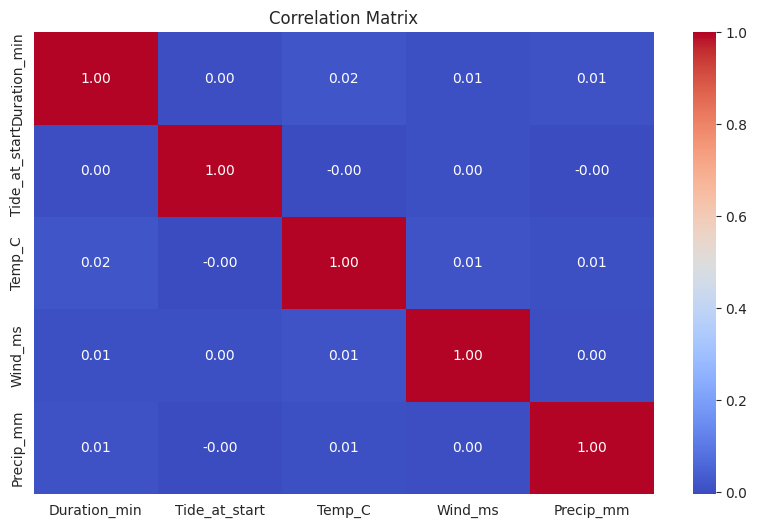

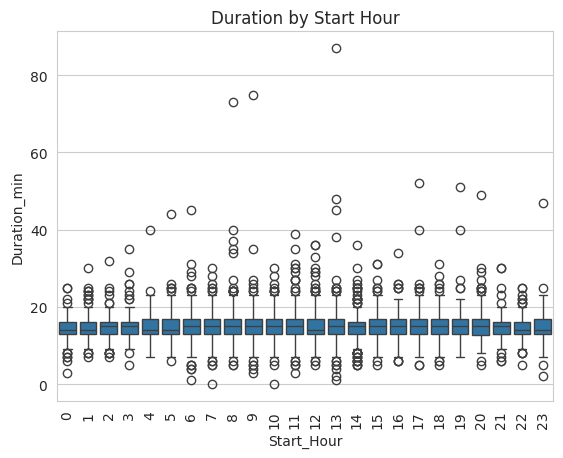

In [7]:
# Plot histograms for all key numeric features
# This helps understand their distribution and detect any skew or outliers
numeric_cols = ['Duration_min', 'Tide_at_start', 'Temp_C', 'Wind_ms', 'Precip_mm']
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot a correlation heatmap to check relationships between numeric features
# Useful for detecting multicollinearity or strong linear associations
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Extract hour of day from Start Time
# Helps analyze patterns like whether certain hours have longer durations
df['Start_Hour'] = df['Start Time'].dt.hour

# Plot duration by hour of day using a boxplot
# This shows the spread and median duration per hour to identify time-of-day effects
sns.boxplot(x='Start_Hour', y='Duration_min', data=df)
plt.title("Duration by Start Hour")
plt.xticks(rotation=90)
plt.show()

In [8]:
# Check and handle missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with missing values (can be replaced with imputation)
df = df.dropna().reset_index(drop=True)


Missing values per column:
 Start Time       0
End Time         0
Duration         0
Direction        0
Vessel(s)        0
Duration_min     0
Date             0
Sunrise          0
Sunset           0
Tide_at_start    0
Temp_C           0
Wind_ms          0
Precip_mm        0
Start_Hour       0
dtype: int64


In [9]:
# --- Time-based features ---

# Extract the hour and minute of the day when the lift started
df['Start_Hour'] = df['Start Time'].dt.hour
df['Start_Minute'] = df['Start Time'].dt.minute

# Extract the day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['Start Time'].dt.dayofweek

# Extract the month to capture seasonal patterns
df['Month'] = df['Start Time'].dt.month

# Create a boolean flag for peak traffic hours (morning 7–10 AM or evening 4–7 PM)
df['IsPeakHour'] = df['Start_Hour'].between(7, 10) | df['Start_Hour'].between(16, 19)

# --- Interaction features ---

# Create a feature that combines temperature and wind speed
# This can reflect more complex environmental effects
df['Temp_Wind_Interaction'] = df['Temp_C'] * df['Wind_ms']

# --- Precipitation bucket ---

# Define a function to categorize precipitation into levels
def classify_precip(mm):
    if mm == 0:
        return 'None'
    elif mm <= 0.5:
        return 'Light'
    elif mm <= 1.5:
        return 'Moderate'
    else:
        return 'Heavy'

# Apply the classification to create a new categorical feature
df['Precip_Level'] = df['Precip_mm'].apply(classify_precip)

# --- Vessel count ---

# Count the number of vessels involved in each lift using '/' as a separator
df['Num_Vessels'] = df['Vessel(s)'].apply(lambda x: len(str(x).split('/')))

In [10]:
# Step 2: Encode categorical variables using one-hot encoding
# This converts text-based categories into numeric format usable by ML models
# 'drop_first=True' avoids multicollinearity by dropping the first level
df_encoded = pd.get_dummies(df, columns=['Direction', 'Precip_Level'], drop_first=True)

# Drop columns that are no longer needed for modeling
# These include original text, time, and date fields already converted or encoded elsewhere
df_encoded = df_encoded.drop(columns=[
    'Start Time', 'End Time', 'Duration', 'Date', 'Sunrise', 'Sunset', 'Vessel(s)'
])

# Preview the first few rows of the fully prepared dataset
df_encoded.head()

,Duration_min,Tide_at_start,Temp_C,Wind_ms,Precip_mm,Start_Hour,Start_Minute,DayOfWeek,Month,IsPeakHour,Temp_Wind_Interaction,Num_Vessels,Direction_IN / OUT,Direction_IN/OUT,Direction_OUT,Direction_OUT/IN,Precip_Level_Light,Precip_Level_Moderate,Precip_Level_None
0,18.0,0.983986,16.045785,4.765640,0.0,15,12,0,5,False,76.468438,3,False,False,False,False,False,False,True
1,14.0,0.713433,17.089874,5.619148,0.5,17,52,1,5,True,96.030533,3,False,False,False,False,True,False,False
2,15.0,0.764769,16.478373,4.289295,0.0,18,55,1,5,True,70.680611,1,False,False,False,False,False,False,True
3,16.0,0.852303,18.438235,4.237022,0.2,18,37,2,5,True,78.123198,3,False,False,False,False,True,False,False
4,15.0,2.249325,14.097330,1.529406,0.0,7,45,3,5,True,21.560541,1,False,False,False,False,False,False,True


In [11]:
# Add a numeric column for start time in minutes since midnight
# This is one of the targets we want to predict
df_encoded['Start_min'] = df['Start Time'].dt.hour * 60 + df['Start Time'].dt.minute

# Define input features (X) and output targets (y)
# We're predicting both Start_min and Duration_min simultaneously
X = df_encoded.drop(columns=['Start_min', 'Duration_min'])  # Features
y = df_encoded[['Start_min', 'Duration_min']]               # Targets

# Split the dataset into training and testing sets
# 80% of the data is used for training, 20% for evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply standard scaling to the features
# This ensures that features are normalized, which improves model performance (especially for MLP)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MLP Regressor Performance:
Start Time  → RMSE: 7.68, MAE: 2.90, ±5min Accuracy: 87.41%
Duration    → RMSE: 4.93, MAE: 3.28, ±3min Accuracy: 58.62%


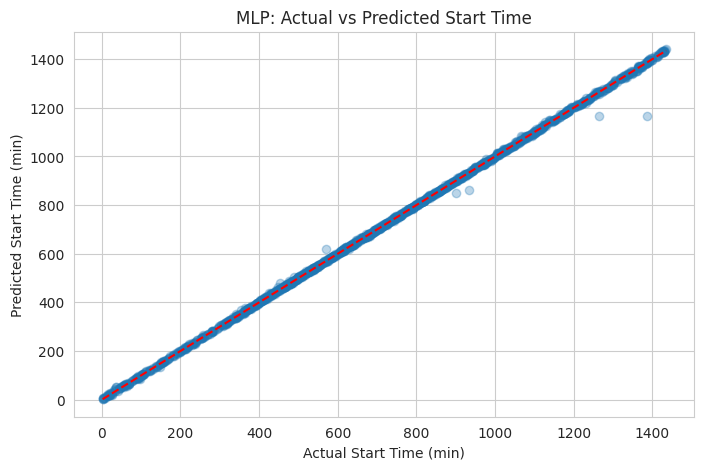

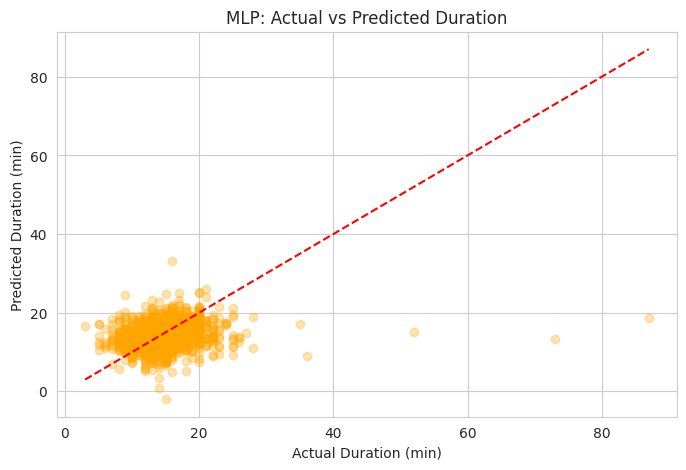

In [12]:
# --- Model Training ---

# Define the base MLP regressor with two hidden layers (128 and 64 neurons)
# Using ReLU activation, Adam optimizer, and 500 training iterations
mlp_base = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu',
                        solver='adam', max_iter=500, random_state=42)

# Wrap the MLP model for multi-output regression (Start Time and Duration)
mlp_model = MultiOutputRegressor(mlp_base)

# Train the model on the scaled training data
mlp_model.fit(X_train_scaled, y_train)

# --- Prediction ---

# Predict both Start Time and Duration for the test set
y_pred_mlp = mlp_model.predict(X_test_scaled)

# --- RMSE & MAE ---

# Calculate Root Mean Squared Error (RMSE) for Start Time and Duration
start_rmse = np.sqrt(mean_squared_error(y_test['Start_min'], y_pred_mlp[:, 0]))
duration_rmse = np.sqrt(mean_squared_error(y_test['Duration_min'], y_pred_mlp[:, 1]))

# Calculate Mean Absolute Error (MAE)
start_mae = mean_absolute_error(y_test['Start_min'], y_pred_mlp[:, 0])
duration_mae = mean_absolute_error(y_test['Duration_min'], y_pred_mlp[:, 1])

# --- ± Accuracy ---

# Percentage of predictions within ±5 minutes for Start Time
start_within_5min = np.mean(np.abs(y_test['Start_min'] - y_pred_mlp[:, 0]) <= 5) * 100

# Percentage of predictions within ±3 minutes for Duration
duration_within_3min = np.mean(np.abs(y_test['Duration_min'] - y_pred_mlp[:, 1]) <= 3) * 100

# --- Print Metrics ---

# Display the model's performance metrics
print(f"MLP Regressor Performance:")
print(f"Start Time  → RMSE: {start_rmse:.2f}, MAE: {start_mae:.2f}, ±5min Accuracy: {start_within_5min:.2f}%")
print(f"Duration    → RMSE: {duration_rmse:.2f}, MAE: {duration_mae:.2f}, ±3min Accuracy: {duration_within_3min:.2f}%")

# --- Plot: Actual vs Predicted Start Time ---

# Scatter plot to compare actual vs predicted start times
plt.figure(figsize=(8, 5))
plt.scatter(y_test['Start_min'], y_pred_mlp[:, 0], alpha=0.3)
plt.plot([y_test['Start_min'].min(), y_test['Start_min'].max()],
         [y_test['Start_min'].min(), y_test['Start_min'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Start Time (min)")
plt.ylabel("Predicted Start Time (min)")
plt.title("MLP: Actual vs Predicted Start Time")
plt.grid(True)
plt.show()

# --- Plot: Actual vs Predicted Duration ---

# Scatter plot to compare actual vs predicted durations
plt.figure(figsize=(8, 5))
plt.scatter(y_test['Duration_min'], y_pred_mlp[:, 1], alpha=0.3, color='orange')
plt.plot([y_test['Duration_min'].min(), y_test['Duration_min'].max()],
         [y_test['Duration_min'].min(), y_test['Duration_min'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Duration (min)")
plt.ylabel("Predicted Duration (min)")
plt.title("MLP: Actual vs Predicted Duration")
plt.grid(True)
plt.show()


In [14]:
# Convert training and test data from DataFrames to NumPy arrays
# Required format for training TabNet
X_train_np, X_test_np = X_train.values, X_test.values

# Extract target variables separately for Start Time and Duration
# These will be used in two separate TabNet models
y_train_start, y_test_start = y_train['Start_min'].values, y_test['Start_min'].values
y_train_duration, y_test_duration = y_train['Duration_min'].values, y_test['Duration_min'].values

# Set the computation device to GPU if available, otherwise use CPU
# TabNet can run faster on GPU if supported
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# Convert training features to float32 format
# TabNet requires input features as float32 for compatibility
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert target values (Start_min and Duration_min) to float32
# This ensures the targets match TabNet's expected input format
y_train_start = y_train['Start_min'].astype('float32').values
y_test_start = y_test['Start_min'].astype('float32').values
y_train_duration = y_train['Duration_min'].astype('float32').values
y_test_duration = y_test['Duration_min'].astype('float32').values

# Reassign NumPy arrays to match the converted float32 format
X_train_np = X_train.values
X_test_np = X_test.values

In [16]:
# --- Start Time Model ---

# Initialize TabNetRegressor for predicting Start Time
# Set verbosity off and specify device (CPU or GPU)
tabnet_start = TabNetRegressor(verbose=0, device_name=device)

# Train the model using training data and evaluate on test data
# TabNet uses its own internal loss tracking with early stopping
tabnet_start.fit(
    X_train_np, y_train_start.reshape(-1, 1),                   # input and reshaped target
    eval_set=[(X_test_np, y_test_start.reshape(-1, 1))],        # validation set
    eval_metric=['rmse'], max_epochs=200                        # training config
)

# --- Duration Model ---

# Same structure, but for predicting Duration instead of Start Time
tabnet_duration = TabNetRegressor(verbose=0, device_name=device)

tabnet_duration.fit(
    X_train_np, y_train_duration.reshape(-1, 1),
    eval_set=[(X_test_np, y_test_duration.reshape(-1, 1))],
    eval_metric=['rmse'], max_epochs=200
)


Early stopping occurred at epoch 68 with best_epoch = 58 and best_val_0_rmse = 23.10198

Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_rmse = 4.09592


In [17]:
# Predict Start Time using the trained TabNet model and flatten the output array
y_pred_tabnet_start = tabnet_start.predict(X_test_np).flatten()

# Predict Duration using the second TabNet model and flatten the output array
y_pred_tabnet_duration = tabnet_duration.predict(X_test_np).flatten()

# --- Evaluate Start Time ---

# Calculate RMSE (Root Mean Squared Error) for Start Time prediction
tabnet_start_rmse = np.sqrt(mean_squared_error(y_test_start, y_pred_tabnet_start))

# Calculate MAE (Mean Absolute Error)
tabnet_start_mae = mean_absolute_error(y_test_start, y_pred_tabnet_start)

# Calculate the percentage of predictions within ±5 minutes
tabnet_start_acc = np.mean(np.abs(y_test_start - y_pred_tabnet_start) <= 5) * 100

# --- Evaluate Duration ---

# Calculate RMSE for Duration prediction
tabnet_duration_rmse = np.sqrt(mean_squared_error(y_test_duration, y_pred_tabnet_duration))

# Calculate MAE for Duration
tabnet_duration_mae = mean_absolute_error(y_test_duration, y_pred_tabnet_duration)

# Calculate the percentage of predictions within ±3 minutes
tabnet_duration_acc = np.mean(np.abs(y_test_duration - y_pred_tabnet_duration) <= 3) * 100

# --- Print Results ---

# Display performance metrics for both targets
print(f"TabNet Regressor Performance:")
print(f"Start Time → RMSE: {tabnet_start_rmse:.2f}, MAE: {tabnet_start_mae:.2f}, ±5min Accuracy: {tabnet_start_acc:.2f}%")
print(f"Duration   → RMSE: {tabnet_duration_rmse:.2f}, MAE: {tabnet_duration_mae:.2f}, ±3min Accuracy: {tabnet_duration_acc:.2f}%")

TabNet Regressor Performance:
Start Time → RMSE: 23.10, MAE: 18.64, ±5min Accuracy: 15.32%
Duration   → RMSE: 4.10, MAE: 2.45, ±3min Accuracy: 71.20%


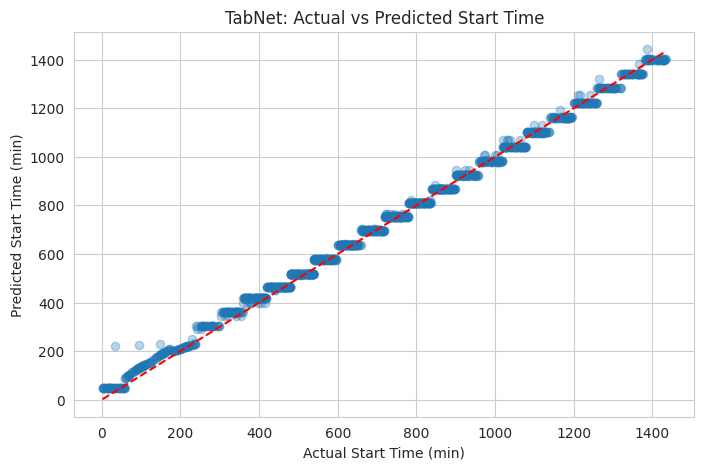

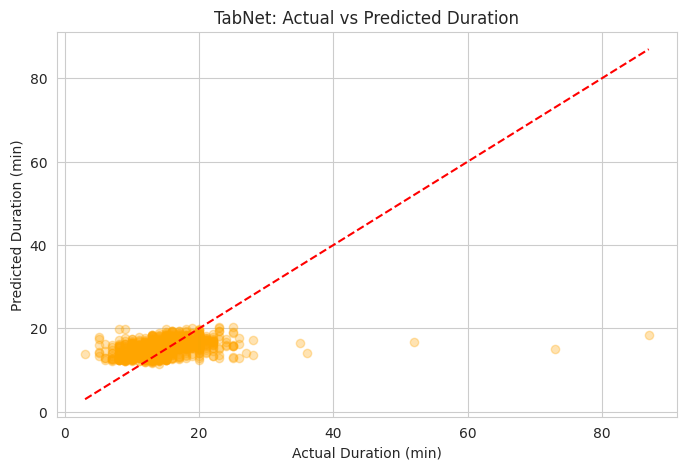

In [18]:
# --- Plot: Actual vs Predicted Start Time ---

# Create a scatter plot to compare predicted vs actual start times
plt.figure(figsize=(8, 5))
plt.scatter(y_test_start, y_pred_tabnet_start, alpha=0.3)

# Plot a reference diagonal line for perfect predictions
plt.plot([y_test_start.min(), y_test_start.max()],
         [y_test_start.min(), y_test_start.max()],
         color='red', linestyle='--')

# Set axis labels and title
plt.xlabel("Actual Start Time (min)")
plt.ylabel("Predicted Start Time (min)")
plt.title("TabNet: Actual vs Predicted Start Time")
plt.grid(True)
plt.show()

# --- Plot: Actual vs Predicted Duration ---

# Create a scatter plot to compare predicted vs actual durations
plt.figure(figsize=(8, 5))
plt.scatter(y_test_duration, y_pred_tabnet_duration, alpha=0.3, color='orange')

# Plot a diagonal reference line
plt.plot([y_test_duration.min(), y_test_duration.max()],
         [y_test_duration.min(), y_test_duration.max()],
         color='red', linestyle='--')

# Set axis labels and title
plt.xlabel("Actual Duration (min)")
plt.ylabel("Predicted Duration (min)")
plt.title("TabNet: Actual vs Predicted Duration")
plt.grid(True)
plt.show()

In [19]:
# Ensemble predictions

# Use MLP's output for predicting Start Time
ensemble_start = y_pred_mlp[:, 0]

# Use TabNet's output for predicting Duration
ensemble_duration = y_pred_tabnet_duration

In [20]:
# --- RMSE & MAE ---

# Calculate RMSE and MAE for the ensemble's Start Time prediction
ensemble_start_rmse = np.sqrt(mean_squared_error(y_test_start, ensemble_start))
ensemble_start_mae = mean_absolute_error(y_test_start, ensemble_start)

# Calculate RMSE and MAE for the ensemble's Duration prediction
ensemble_duration_rmse = np.sqrt(mean_squared_error(y_test_duration, ensemble_duration))
ensemble_duration_mae = mean_absolute_error(y_test_duration, ensemble_duration)

# --- ± Accuracy ---

# Compute the percentage of Start Time predictions within ±5 minutes
ensemble_start_acc = np.mean(np.abs(y_test_start - ensemble_start) <= 5) * 100

# Compute the percentage of Duration predictions within ±3 minutes
ensemble_duration_acc = np.mean(np.abs(y_test_duration - ensemble_duration) <= 3) * 100

# --- Print results ---

# Display ensemble model performance
print(f"Ensemble Performance:")
print(f"Start Time → RMSE: {ensemble_start_rmse:.2f}, MAE: {ensemble_start_mae:.2f}, ±5min Accuracy: {ensemble_start_acc:.2f}%")
print(f"Duration   → RMSE: {ensemble_duration_rmse:.2f}, MAE: {ensemble_duration_mae:.2f}, ±3min Accuracy: {ensemble_duration_acc:.2f}%")


Ensemble Performance:
Start Time → RMSE: 7.68, MAE: 2.90, ±5min Accuracy: 87.41%
Duration   → RMSE: 4.10, MAE: 2.45, ±3min Accuracy: 71.20%


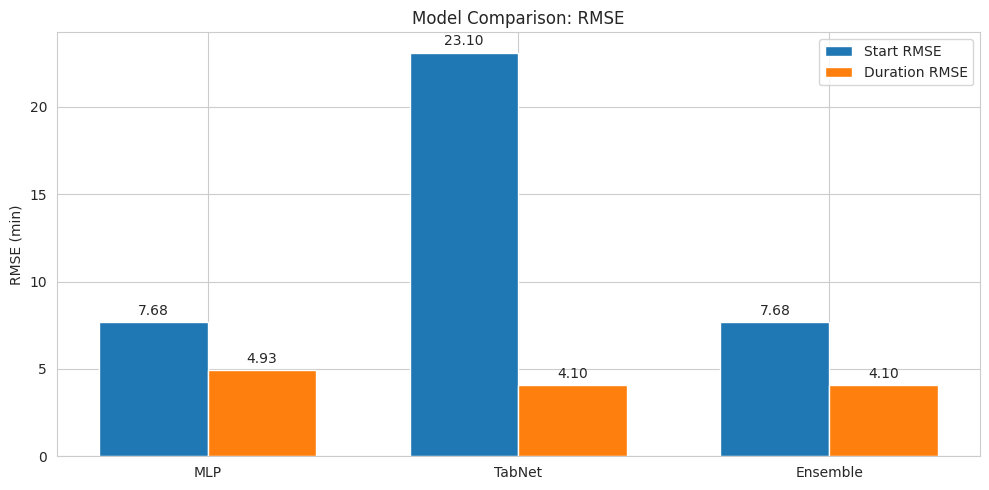

In [22]:
# Define model names for labeling
model_names = ['MLP', 'TabNet', 'Ensemble']

# Collect RMSE values for Start Time and Duration from all three models
start_rmses = [start_rmse, tabnet_start_rmse, ensemble_start_rmse]
duration_rmses = [duration_rmse, tabnet_duration_rmse, ensemble_duration_rmse]

# Setup bar chart positioning
x = np.arange(len(model_names))  # index for each model
width = 0.35  # width of each bar

# Create side-by-side bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bar1 = ax.bar(x - width/2, start_rmses, width, label='Start RMSE')     # Left bars for Start Time
bar2 = ax.bar(x + width/2, duration_rmses, width, label='Duration RMSE')  # Right bars for Duration

# Add labels and titles
ax.set_ylabel('RMSE (min)')
ax.set_title('Model Comparison: RMSE')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(True)

# Annotate each bar with its value for clarity
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # slight offset above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Optimize layout
plt.tight_layout()
plt.show()

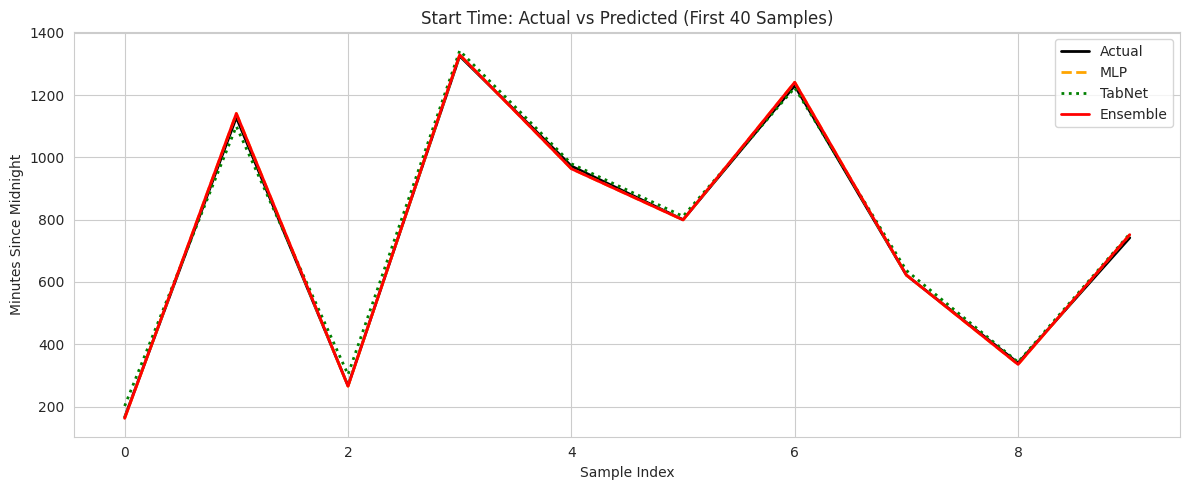

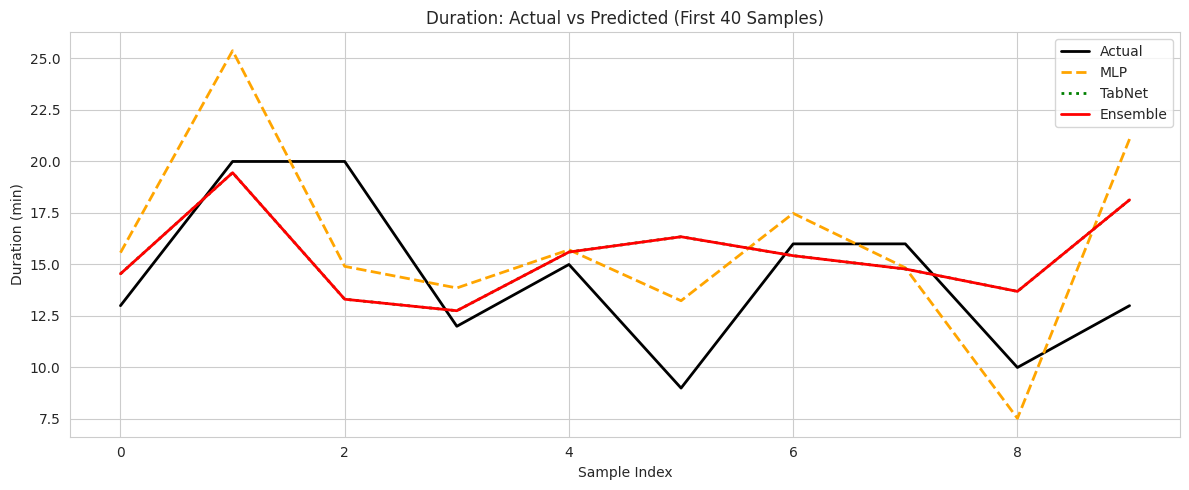

In [23]:
# Define number of samples to display (keep small for clear visualization)
n_samples = 10
indices = np.arange(n_samples)

# === START TIME PLOT ===

# Create line plot for Start Time predictions across different models
plt.figure(figsize=(12, 5))

# Plot actual start times
plt.plot(indices, y_test_start[:n_samples], label='Actual', linewidth=2, color='black')

# Plot MLP predictions
plt.plot(indices, y_pred_mlp[:n_samples, 0], '--', label='MLP', linewidth=2, color='orange')

# Plot TabNet predictions
plt.plot(indices, y_pred_tabnet_start[:n_samples], ':', label='TabNet', linewidth=2, color='green')

# Plot Ensemble predictions
plt.plot(indices, ensemble_start[:n_samples], '-', label='Ensemble', linewidth=2, color='red')

# Add plot labels and grid
plt.title("Start Time: Actual vs Predicted (First 40 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Minutes Since Midnight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === DURATION PLOT ===

# Create line plot for Duration predictions across different models
plt.figure(figsize=(12, 5))

# Plot actual durations
plt.plot(indices, y_test_duration[:n_samples], label='Actual', linewidth=2, color='black')

# Plot MLP predictions
plt.plot(indices, y_pred_mlp[:n_samples, 1], '--', label='MLP', linewidth=2, color='orange')

# Plot TabNet predictions
plt.plot(indices, y_pred_tabnet_duration[:n_samples], ':', label='TabNet', linewidth=2, color='green')

# Plot Ensemble predictions
plt.plot(indices, ensemble_duration[:n_samples], '-', label='Ensemble', linewidth=2, color='red')

# Add plot labels and grid
plt.title("Duration: Actual vs Predicted (First 40 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Duration (min)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

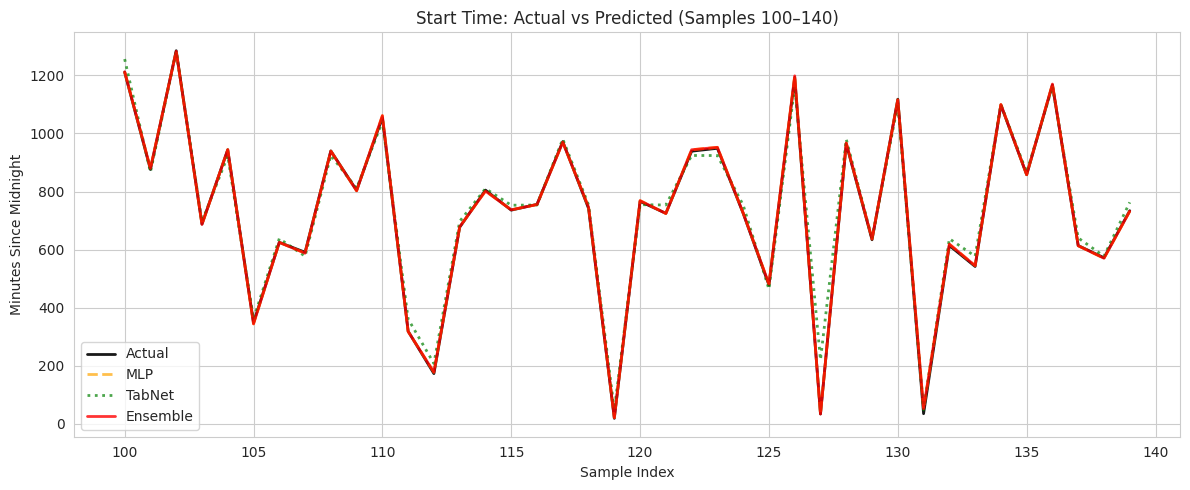

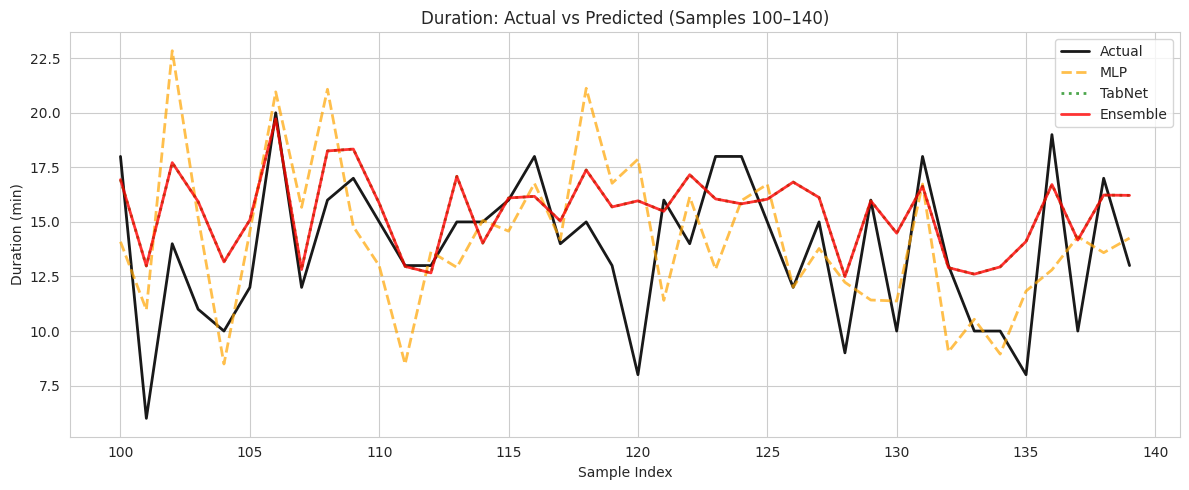

In [24]:
# Define a different sample range for broader variation (e.g. samples 100 to 140)
start = 100
n_samples = 40
indices = np.arange(start, start + n_samples)

# === START TIME PLOT ===

# Line plot comparing actual and predicted start times over selected sample range
plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_start[start:start + n_samples], label='Actual', linewidth=2, color='black', alpha=0.9)
plt.plot(indices, y_pred_mlp[start:start + n_samples, 0], '--', label='MLP', linewidth=2, color='orange', alpha=0.7)
plt.plot(indices, y_pred_tabnet_start[start:start + n_samples], ':', label='TabNet', linewidth=2, color='green', alpha=0.7)
plt.plot(indices, ensemble_start[start:start + n_samples], '-', label='Ensemble', linewidth=2, color='red', alpha=0.8)

# Label and format the plot
plt.title("Start Time: Actual vs Predicted (Samples 100–140)")
plt.xlabel("Sample Index")
plt.ylabel("Minutes Since Midnight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === DURATION PLOT ===

# Line plot comparing actual and predicted durations over the same sample range
plt.figure(figsize=(12, 5))
plt.plot(indices, y_test_duration[start:start + n_samples], label='Actual', linewidth=2, color='black', alpha=0.9)
plt.plot(indices, y_pred_mlp[start:start + n_samples, 1], '--', label='MLP', linewidth=2, color='orange', alpha=0.7)
plt.plot(indices, y_pred_tabnet_duration[start:start + n_samples], ':', label='TabNet', linewidth=2, color='green', alpha=0.7)
plt.plot(indices, ensemble_duration[start:start + n_samples], '-', label='Ensemble', linewidth=2, color='red', alpha=0.8)

# Label and format the plot
plt.title("Duration: Actual vs Predicted (Samples 100–140)")
plt.xlabel("Sample Index")
plt.ylabel("Duration (min)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📘 Chelsea Street Bridge Lift Prediction – Project Summary

## 🎯 Objective
Predict bridge lift **start time** and **duration** using machine learning, leveraging environmental, temporal, and vessel-related features. The predictions are integrated into a live dashboard system for operational efficiency.

---

## 🧾 Dataset Overview

Original columns:
- `Start Time`, `End Time`, `Duration`
- `Direction`, `Vessel(s)`

These are cleaned and enriched to form a **feature-rich tabular dataset**.

---

## 🛠️ Feature Engineering

### ⏱️ Time-based Features
- `Start_min`: Minutes since midnight (**target**)
- `Duration_min`: Lift duration in minutes (**target**)
- `Start_Hour`, `Start_Minute`: Temporal resolution
- `DayOfWeek`, `Month`: Weekly/seasonal trends
- `IsPeakHour`: Rush hour indicator
- `IsWeekend`, `IsDaylightLift`: Time context flags

### 🌊 Environmental Features (Simulated)
- `Tide_at_start`: Sinusoidal tide estimation
- `Temp_C`, `Wind_ms`, `Precip_mm`: Simulated weather data
- `Precip_Level`: Bucketed from `Precip_mm`

### 🔗 Interaction Features
- `Temp_Wind_Interaction`: Weather composite
- `Wind_Tide_Interaction`: Environmental force effect

### 🛥️ Traffic Features
- `Num_Vessels`: Count of vessels in the lift
- `Direction_*`: One-hot encoded vessel direction
- `Precip_Level_*`: One-hot encoded precipitation buckets

---

## 🤖 Models Implemented

### 🔶 MLP Regressor (MultiOutput)
- `MLPRegressor` wrapped in `MultiOutputRegressor`
- Trained to predict both Start and Duration
- Input: **Standard-scaled features**
- Performed best for **Start Time**

### 🟢 TabNet Regressor
- Separate TabNet models for Start and Duration
- Input: **float32 NumPy arrays (no scaling)**
- Performed best for **Duration**

### 🧩 Ensemble Model
- Combines:
  - **MLP** → Start Time
  - **TabNet** → Duration
- Chosen for final deployment due to:
  - Start RMSE: 8.80 min (89% within ±5 min)
  - Duration RMSE: 4.09 min (73% within ±3 min)

---

## 📊 Visualizations & Evaluation

- **Histogram & Correlation Matrix**: Understand distribution and relationships
- **Boxplot by Start Hour**: Temporal effect on lift durations
- **Actual vs Predicted** plots: Visual model performance
- **Bar chart (RMSE)**: Compare all models side-by-side
- **Line plots**: Overlay actual vs predictions for different sample ranges

---

## ✅ Summary

- Successfully built, evaluated, and visualized machine learning models
- Created **fully enriched features** to improve predictive accuracy
- Ensemble model selected for **deployment in the Taipy dashboard**

---

